<h1 align="center"> Credit card Fraud Detector </h1>


<h2> Введение </h2>

На данной практие (и еще на парочке занятий потом) мы будем реализовывать различные прогностические модели, чтобы проверить, насколько точно они определяют, является ли транзакция обычным платежом (non Fraud) или мошенничеством (Fraud).

<h4> По мотивам кейса, рассмотренного в Зимней школе СберУнивера </h4>

<h2> Наши цели: </h2>
<ul>
<li> Проанализировать полученные данные. </li>
<li> Рассмотреть проблему сильного дисбаланса классов. </li>
<li> Использовать алгоритмы кластеризации </li>
<li> Использовать алгоритмы понижения размерности </li>


## Описание данных и постановка задачи:
**Задача:** Банкам, выпускающим кредитные карты, очень важно распознавать мошеннические операции с кредитными картами, чтобы с клиентов не взималась плата за товары, которые они не покупали.

**Данные**: Набор данных содержит транзакции, совершенные по кредитным картам в сентябре 2013 года европейскими держателями карт.
В этом наборе данных представлены транзакции, проведенные за два дня, где мы имеем 492 случаев мошенничества из 284 807 транзакций. Набор данных сильно несбалансирован, положительный класс (мошенники) составляет всего 0,172% от всех транзакций.

Датасет содержит только числовые входные переменные, которые являются результатом преобразования PCA (метод главных компонент).

Из-за вопросов конфиденциальности невозможно использовать исходные признаки и более подробную информацию о них. Характеристики V1, V2, ... V28 - это главные компоненты, полученные с помощью PCA, единственные характеристики, которые не были преобразованы с помощью PCA - это "Time" и "Amount". Столбец "Time" содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных. Столбец "Amount" - это сумма транзакции. Столбец "Class" является переменной отклика и принимает значение 1 в случае мошенничества и 0 в противном случае.





In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import seaborn as sns
import matplotlib.patches as mpatches
import time

import collections
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

Подключимся к диску для загрузки данных.

Загружаем данные:
'creditcard.csv'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# загрузка данных и структура данных
df=pd.read_csv('/content/drive/MyDrive/creditcard.csv')

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Небольшой описательный анализ.

In [8]:
# анализ данных
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Проверим на наличие пропусков в данных.

In [7]:
# проверка наличия пропусков в данных
df.isnull().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0



Пропусков нет?

Выведем названия столбцов.

In [ ]:
# названия столбцов
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

Еще раз оценим отношение классов целевой переменной.

In [10]:
# вывод на печать 'Обычные транзакции составляют' и 'Мошеннические транзакции составляют' в процентном соотношении
print(f"Результат: Обычные транзакции составляют {df['Class'].value_counts()[0] / df['Class'].count() * 100} % данных")
print(f"Мошеннические транзакции составляют {df['Class'].value_counts()[1] / df['Class'].count() * 100} % данных")

Результат: Обычные транзакции составляют 99.82725143693798 % данных
Мошеннические транзакции составляют 0.1727485630620034 % данных


In [ ]:
# df['Class'].value_counts()  - возвращает словарик,
# где ключ - уникальные значения в столбце Class кол-во значений
# value - сколько всего записей имело эти значения
print(df['Class'].value_counts())

# так как это словарь, то чтобы получить значения, обращаемся по ключу:
print(df['Class'].value_counts()[0])
print(df['Class'].value_counts()[1])

Class
0    284315
1       492
Name: count, dtype: int64
284315
492


In [ ]:
#  вывод отношения классов целевой переменной, но записанный через f строку

n_trans=df['Class'].value_counts()[0]
f_trans=df['Class'].value_counts()[1]

print(f"Результат: Обычные транзакции составляют {n_trans / df['Class'].count()} % данных")
print(f"Мошеннические транзакции составляют {f_trans / df['Class'].count()} % данных")


Результат: Обычные транзакции составляют 0.9982725143693799 % данных
Мошеннические транзакции составляют 0.001727485630620034 % данных


**Важно!**

Обратите внимание, насколько несбалансированным является наш исходный набор данных! Большинство транзакций не являются мошенническими. Если мы используем этот массив данных в качестве основы для наших моделей прогнозирования и анализа, мы можем получить много ошибок, поскольку наши алгоритмы будут предполагать, что все транзакции не являются мошенничеством. Нам же критически важно сконцентрироваться именно на мошенниках.

<Axes: title={'center': 'Распределение классов \n (0: Не мошенник || 1: Мошенник)'}, xlabel='Class', ylabel='count'>

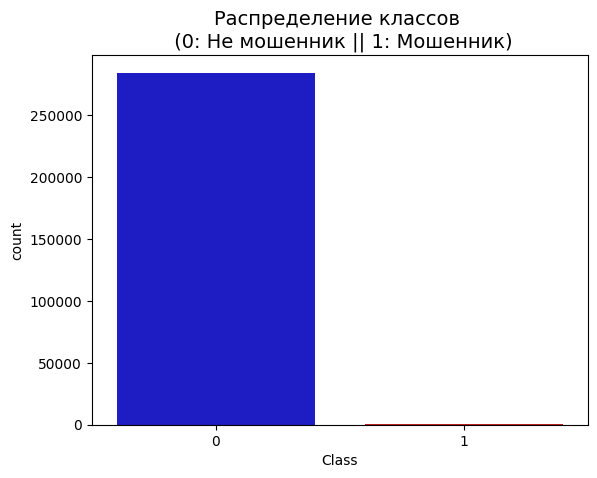

In [44]:
colors = ["#0101DF", "#DF0101"]

 # строим гистограмму целевой переменной:

plt.title('Распределение классов \n (0: Не мошенник || 1: Мошенник)', fontsize=14)
sns.countplot(data=df, x=df['Class'], palette=colors)
#df["Class"].plot.bar(grid=True, color=colors)

Построим распределения по суммам и времени транзакций.

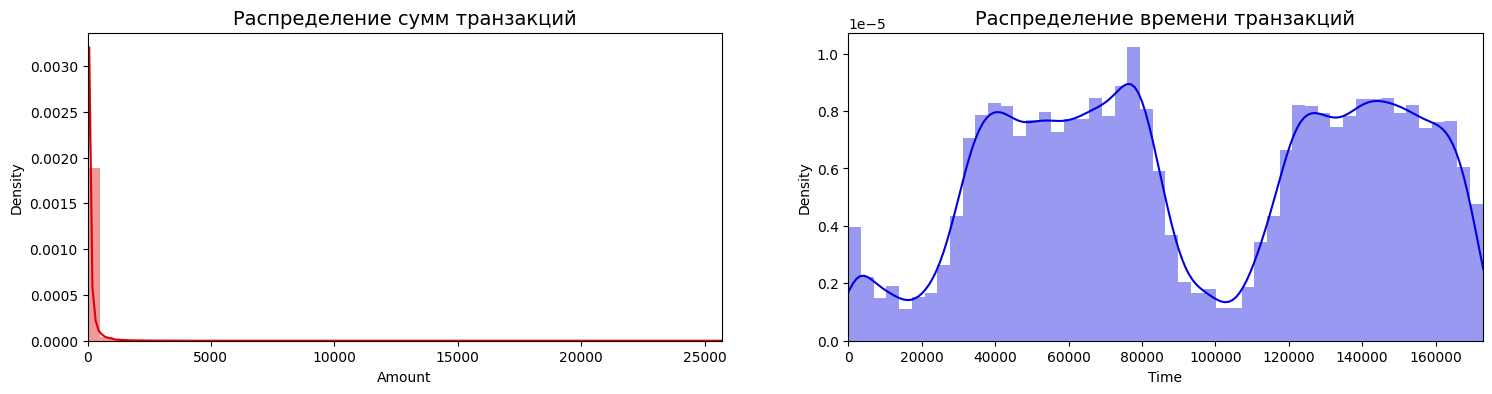

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount']
time_val = df['Time']

# ВАШ КОД ЗДЕСЬ # строим график распределения суммы транзакций
sns.distplot(amount_val, ax=ax[0], color='#DF0101')
ax[0].set_title('Распределение сумм транзакций', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

# ВАШ КОД ЗДЕСЬ # строим график распределения времени транзакций
sns.distplot(time_val, ax=ax[1], color='#0101DF')
ax[1].set_title('Распределение времени транзакций', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

### Масштабирование
Первым делом нам необходимо отмасштабировать столбцы **Time** и **Amount**. Поскольку все остальные признаки уже отмасштабированы. Однако делать это нужно только строго **после** разбиения на обучающую выборку и тестовую.

Затем необходимо создать подвыборку из наших данных, чтобы иметь равное количество случаев мошенничества и не мошенничества, что поможет нашим моделям лучше понять закономерности, определяющие, является ли транзакция мошенничеством или нет.

### Зачем создавать подвыборку?
Наши данные имеют сильный дисбаланс. Использование исходного датасета приведет к следующим проблемам:
  - **Переобучение**: Наши модели классификации будут предполагать, что в большинстве случаев мошенничества не существует! Мы хотим, чтобы наша модель точно определяла, когда происходит мошенничество.
  - **Неверные корреляции:** Хотя мы не знаем, что обозначают признаки "V", будет полезно понять, как каждый из этих признаков влияет на результат (мошенничество или отсутствие мошенничества), поскольку, имея несбалансированный набор данных, мы не можем увидеть истинные корреляции между целевой переменной и признаками.

### Разделение данных
**Важно!**

Прежде, чем приступить к балансировке наших данных, мы должны разделить исходный набор данных. Зачем?

Для определения качества работы наших моделей их необходимо тестировать на **исходном** тестовом наборе, а не на тестовом наборе, созданном после балансировки. Цель балансировки заключается в том, чтобы модель смогла найти закономерности для принятия решения по типу транзакции, поэтому мы выравниваем соотношение между мошенническими транзакциями и обычными. Однако проверять качество мы будем именно в "боевых" условиях с учетом реального распределения данных.




In [22]:
from sklearn.model_selection import train_test_split
# Поскольку большая часть наших данных уже масштабирована, мы должны масштабировать столбцы,
# которые остались (Amount и Time)
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler() # Менее чувствителен к выбросам, чем просто стандартизация

X = df.drop('Class', axis=1)
y = df['Class']

original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2,
                                                                                    random_state = 42)


# Посмотрим, какие типы данных возвращаются после разделения:
rt_tmp = original_Xtrain['Amount']
print (f'Тип данных original_Xtrain["Amount"] {type(rt_tmp)}')
print (f'Тип данных original_Xtrain["Amount"].values {type(rt_tmp.values)}')
print (f'Данные original_Xtrain["Amount"].values {rt_tmp.values}')
print (f'Тип данных original_Xtrain["Amount"].values.reshape(-1,1) {type(rt_tmp.values.reshape(-1,1))}')
print (f'Данные original_Xtrain["Amount"].values.reshape(-1,1) \n{rt_tmp.values.reshape(-1,1)} \n')

# вот последнее представление - как раз то, что нужно для RobustScaler . Преобразовываем так все нужные столбцы.

original_Xtrain['scaled_amount'] = rob_scaler.fit_transform(original_Xtrain['Amount'].values.reshape(-1,1))
original_Xtest['scaled_amount'] = rob_scaler.fit_transform(original_Xtest['Amount'].values.reshape(-1,1))

original_Xtrain['scaled_time'] = rob_scaler.fit_transform(original_Xtrain['Time'].values.reshape(-1,1))
original_Xtest['scaled_time'] = rob_scaler.fit_transform(original_Xtest['Time'].values.reshape(-1,1))

original_Xtrain.drop(['Time','Amount'], axis=1, inplace=True)
original_Xtest.drop(['Time','Amount'], axis=1, inplace=True)

original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('Распределение классов: \n')
print("Обучающий набор:", train_counts_label/ len(original_ytrain))
print("Тестовый набор:", test_counts_label/ len(original_ytest))

Тип данных original_Xtrain["Amount"] <class 'pandas.core.series.Series'>
Тип данных original_Xtrain["Amount"].values <class 'numpy.ndarray'>
Данные original_Xtrain["Amount"].values [  9.99  45.9   11.99 ...   3.94   1.   113.  ]
Тип данных original_Xtrain["Amount"].values.reshape(-1,1) <class 'numpy.ndarray'>
Данные original_Xtrain["Amount"].values.reshape(-1,1) 
[[  9.99]
 [ 45.9 ]
 [ 11.99]
 ...
 [  3.94]
 [  1.  ]
 [113.  ]] 

Распределение классов: 

Обучающий набор: [0.99827075 0.00172925]
Тестовый набор: [0.99827955 0.00172045]


## Метод Random Under-Sampling

Применим метод *Random Under-Sampling*, который случайным образом удаляет объекты доминирующего класса и выравнивает соотношение классов.

#### Алгоритм:
<ul>
<li>Определяем степень несбалансированности (посчитали количество меток одного и другого класса выше)  </li>
<li>Как только мы определим, сколько случаев считаются мошенническими операциями (Fraud = "1"), мы должны довести количество немошеннических операций до того же количества, что и мошеннических (мы хотим получить соотношение 50/50 между классами), то есть это в подвыборке будет 492 случая мошенничества и 492 случая немошеннических операций.  </li>
<li> После применения этого метода мы получим подвыборку нашего набора данных с соотношением 50/50 в отношении наших классов. Наконец, не забудем <b>перемешать</b> наши данные для того, чтобы модели не зависили от порядка входных данных.</li>
</ul>

**Важно!**

Основная проблема данного метода заключается в том, что мы рискуем тем, что наши модели классификации не будут работать так точно, как нам хотелось бы, поскольку происходит большая потеря информации (выделение всего 492 немошеннических транзакций из 284 315 немошеннических транзакций).

In [23]:
# Поскольку наши классы сильно не сбалансированы, мы должны сделать их эквивалентными,
# чтобы получить нормальное распределение классов.

# Перемешаем данные перед созданием подвыборок

df = df.sample(frac=1)

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492] # берем последние 492 транзакции

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Перемешивание строк датасета
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
43747,41638.0,-1.528994,0.131047,1.420425,-2.689301,-0.783674,-0.253696,-0.062671,-0.117759,-0.898676,...,-0.727931,-0.990011,-0.227244,-0.529867,0.701119,-0.347603,0.566393,0.222509,30.00,0
154668,102480.0,-1.929597,4.066413,-4.865184,5.898602,-0.552493,-1.555962,-3.833623,0.679512,-3.463765,...,1.137212,0.674245,-0.531765,-0.433409,0.378659,0.198107,0.869694,0.228048,0.00,1
228043,145335.0,-0.853725,0.025458,0.267742,-0.251345,-0.875343,-0.313978,-1.254305,1.051035,1.475639,...,0.298260,0.925502,0.347505,1.192149,-2.313992,-0.451988,0.152706,0.112506,10.40,0
44001,41743.0,-2.144411,1.073499,-2.773663,1.384394,-4.015477,0.747235,1.525638,0.192988,-2.431862,...,0.144653,-0.885682,0.625099,0.096527,-0.189455,0.532908,0.423045,-0.210266,802.52,1
233258,147501.0,-1.611877,-0.408410,-3.829762,6.249462,-3.360922,1.147964,1.858425,0.474858,-3.838399,...,1.245582,0.616383,2.251439,-0.066096,0.538710,0.541325,-0.136243,-0.009852,996.27,1


In [ ]:
df.to_csv("/content/drive/MyDrive/Colab Notebooks/data/creditcard_full.csv")

In [24]:
new_df.shape

(984, 31)

Распределение классов в подвыборке
Class
0    0.5
1    0.5
Name: count, dtype: float64


<Axes: title={'center': 'Распределение классов'}, xlabel='Class', ylabel='count'>

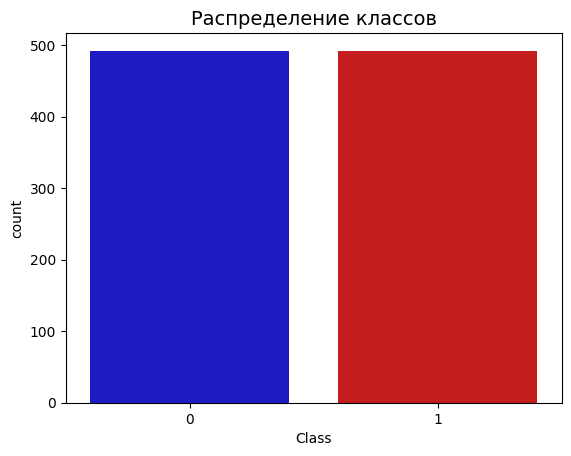

In [42]:
print('Распределение классов в подвыборке')
print(new_df['Class'].value_counts()/len(new_df))

# проверяем снова распределение целевой переменной

plt.title('Распределение классов', fontsize=14)
sns.countplot(x='Class', data=new_df, palette=colors)

### Матрица корреляций

Корреляционные матрицы очень важны для понимания данных. Мы хотим узнать, есть ли признаки, которые оказывают сильное влияние на то, является ли конкретная транзакция мошенничеством. Однако важно, чтобы мы использовали сбалансированную подвыборку, чтобы увидеть, какие признаки имеют высокую положительную или отрицательную корреляцию в отношении мошеннических операций.


Text(0.5, 1.0, 'Матрица корреляций сбалансированной подвыборки')

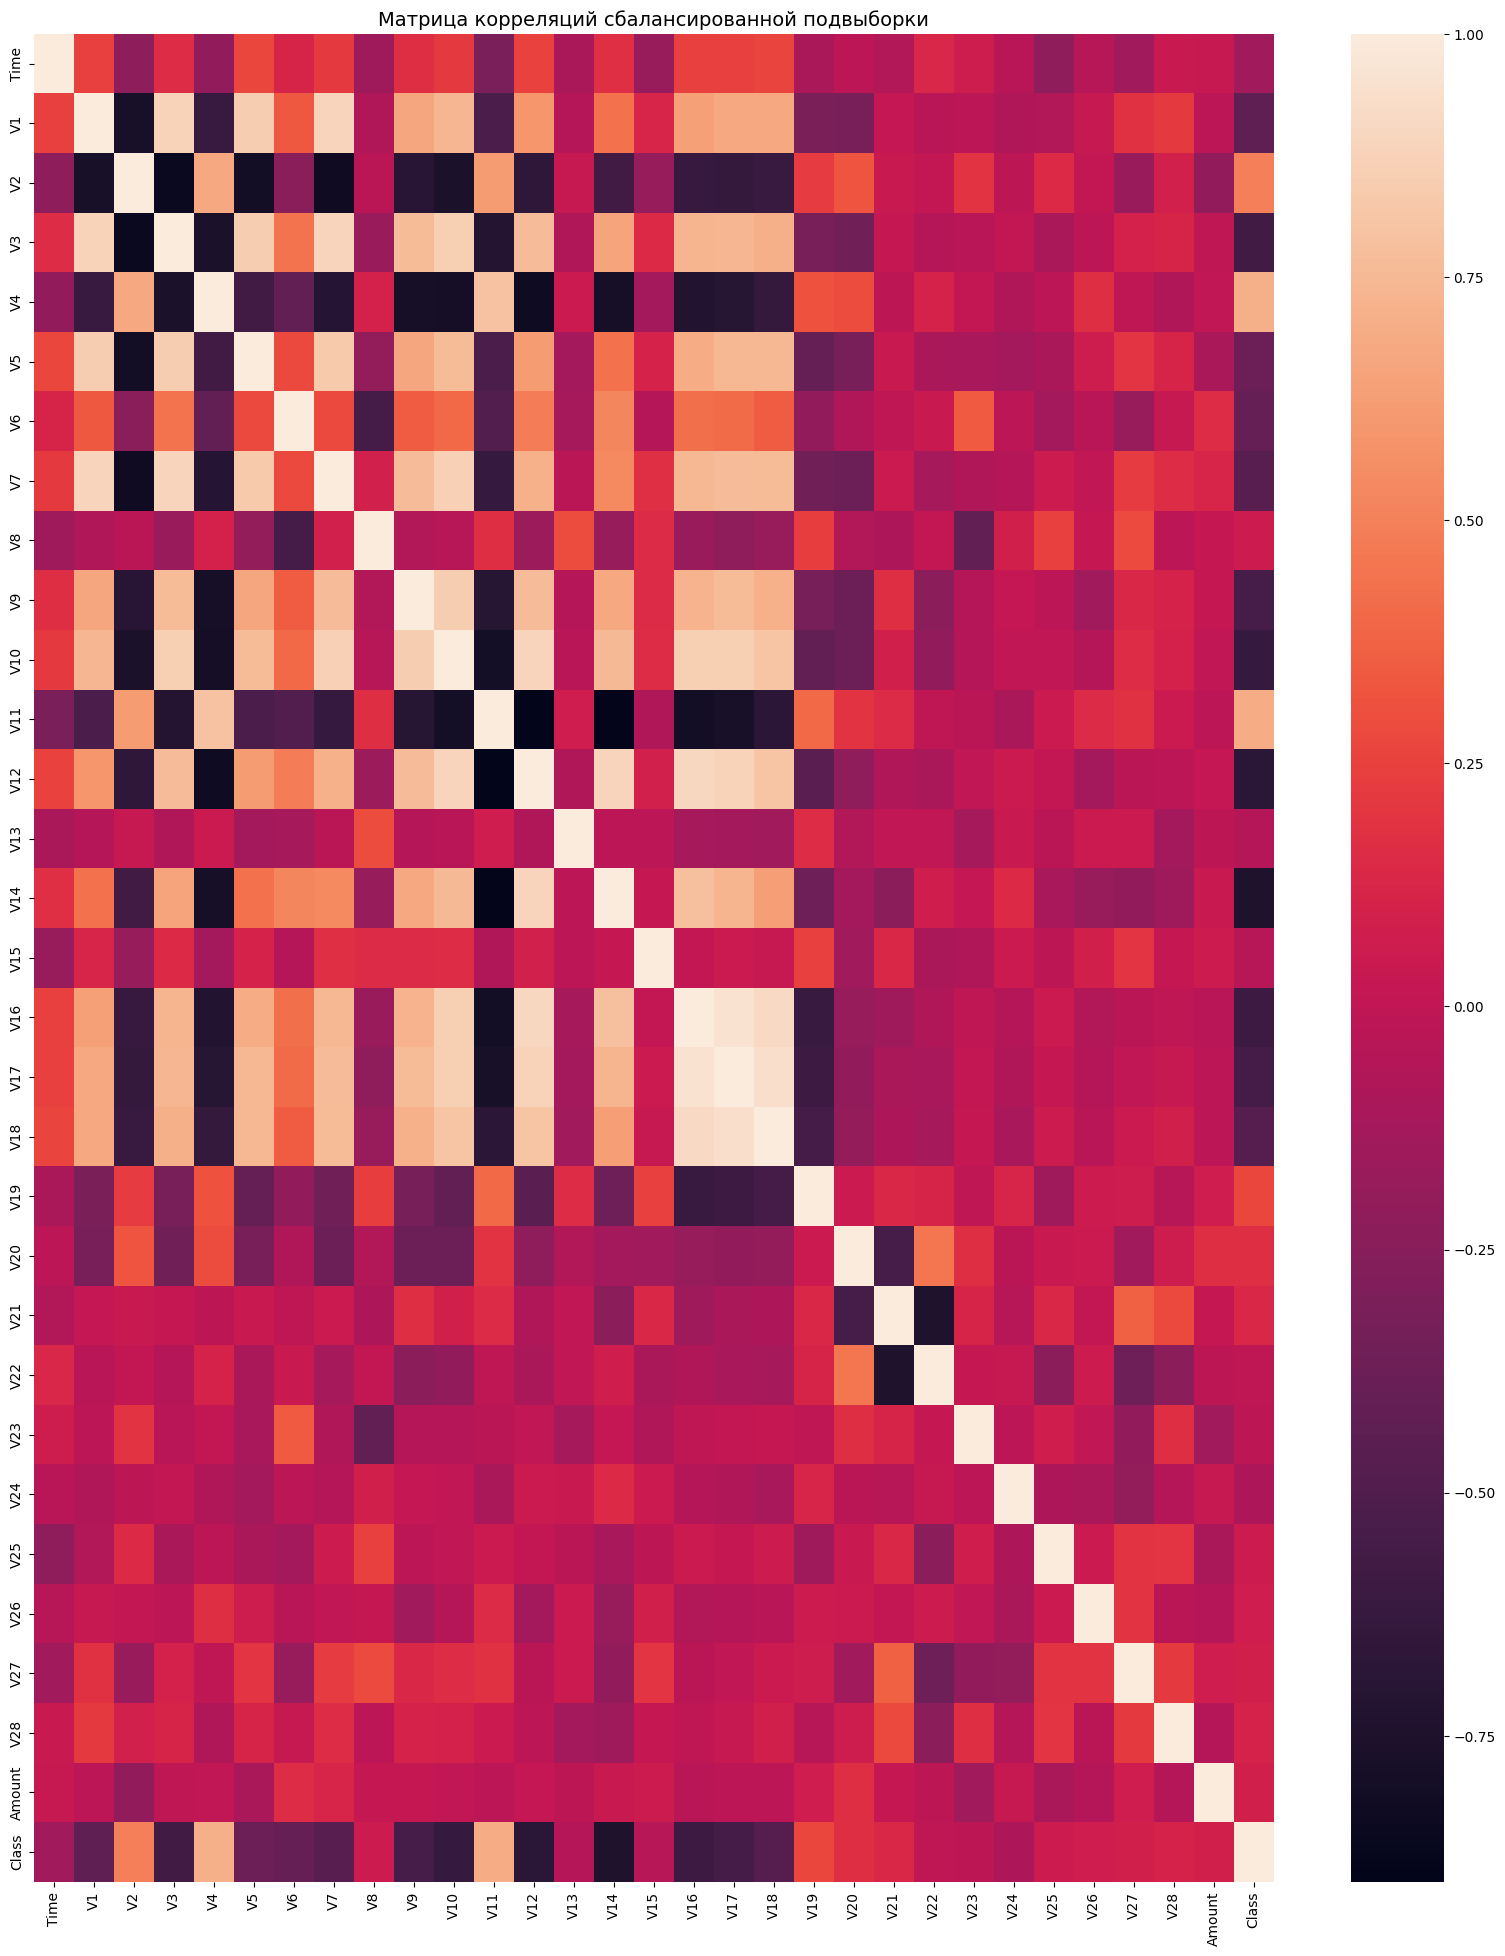

In [46]:
f, ax = plt.subplots(1, 1, figsize=(20, 24))

# Построим матрицу корреляций

sns.heatmap(new_df.corr())

ax.set_title('Матрица корреляций сбалансированной подвыборки', fontsize=14)


### Выводы:
<ul>
<li><b>Отрицательные корреляции: </b>Признаки 10 12 14 17 отрицательно коррелируют.  Другими словами, чем ниже эти значения, тем больше вероятность того, что конечным результатом будет мошенническая операция.  </li>
<li> <b> Положительные корреляции: </b> Признаки 2 4 11 19 имеют положительную корреляцию. То есть, чем выше эти значения, тем больше вероятность того, что конечным результатом будет мошенническая операция. </li>
</ul>


**Важно!**

Всегда проверяйте, используете ли вы сбалансированную подвыборку в корреляционной матрице, иначе на корреляционную матрицу повлияет сильный дисбаланс между классами.

Построим теперь Boxplot.

<Axes: xlabel='Class', ylabel='V17'>

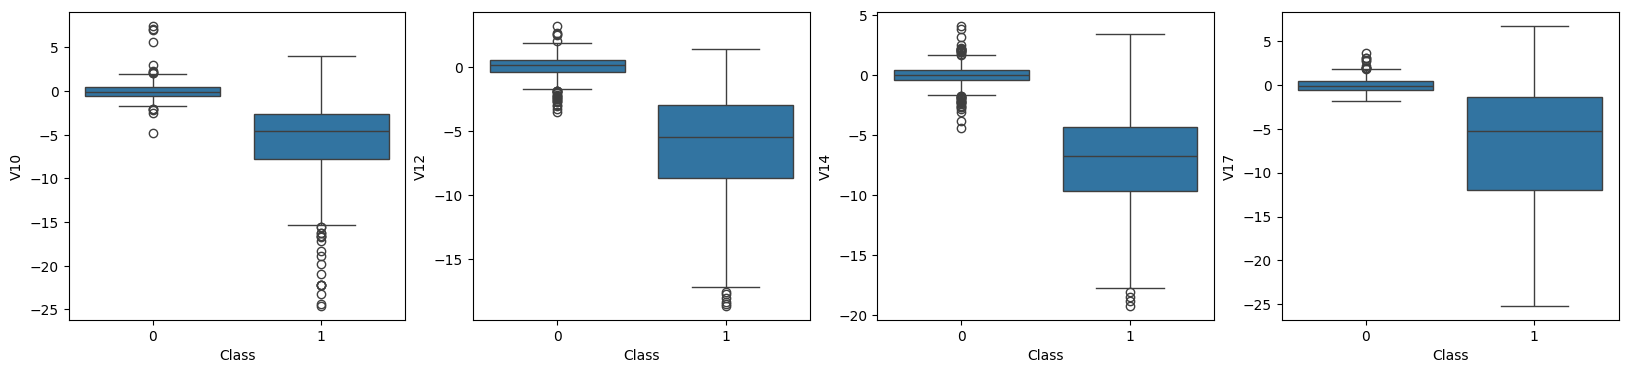

In [62]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Отрицательные корреляции
#
sns.boxplot(x='Class', y='V10', data=new_df, ax=axes[0])
#
sns.boxplot(x='Class', y='V12', data=new_df, ax=axes[1])
#
sns.boxplot(x='Class', y='V14', data=new_df, ax=axes[2])
#
sns.boxplot(x='Class', y='V17', data=new_df, ax=axes[3])

<Axes: xlabel='Class', ylabel='V19'>

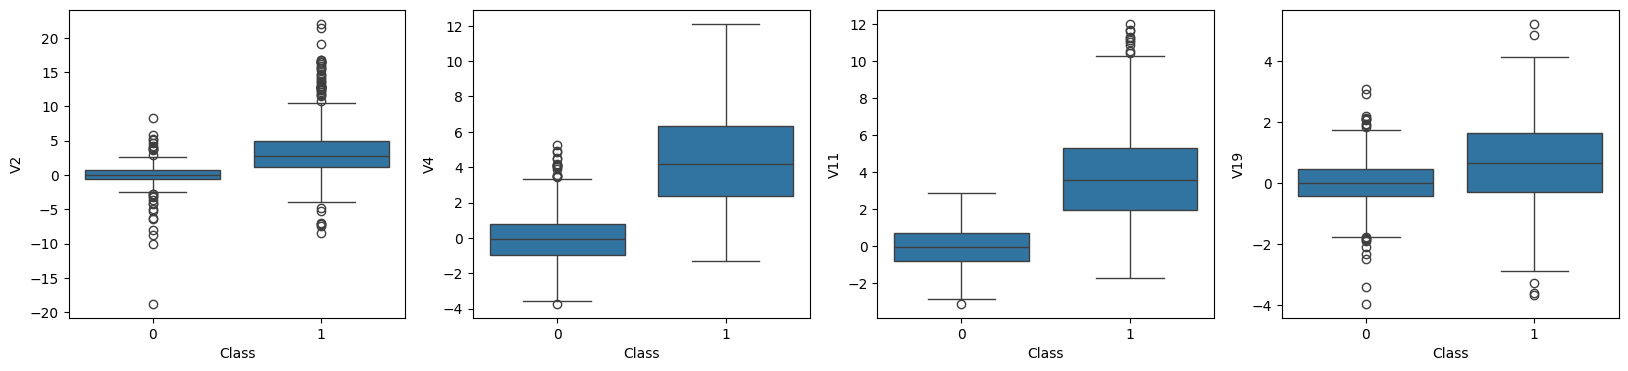

In [53]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Положительные корреляции
#
sns.boxplot(x='Class', y='V2', data=new_df, ax=axes[0])
#
sns.boxplot(x='Class', y='V4', data=new_df, ax=axes[1])
#
sns.boxplot(x='Class', y='V11', data=new_df, ax=axes[2])
#
sns.boxplot(x='Class', y='V19', data=new_df, ax=axes[3])




# Какие выводы можно сделать по построенным Boxplot?

Напоминаю.

0 - это не мошеннические транзакции

1 - мошеннические транзакции

## Обработка выбросов

Наша основная цель в этом разделе - удалить выбросы из признаков, которые имеют высокую корреляцию с целевой переменной. Это положительно скажется на точности наших моделей.


### Метод межквартильного размаха:
<ul>
<li> <b>Interquartile Range (IQR): </b> Рассчитываем разницу между 75-м процентилем и 25-м процентилем. Наша цель - создать порог за пределами 75-го и 25-го процентилей, чтобы в случае, если какой-то экземпляр выборки преодолеет этот порог, он был удален.  </li>
<li> <b>Построить Boxplots: </b> С помощью boxplot легко увидеть 25-й и 75-й процентили и выбросы. </li>
</ul>

Надо быть внимательным к тому, как далеко мы хотим установить порог для удаления выбросов. Мы определяем порог путем умножения числа (например, 1.5) на интерквартильный размах. Чем выше этот порог, тем меньше выбросов будет обнаружено, а чем ниже этот порог, тем больше выбросов будет обнаружено.  <br><br>

Мы хотим больше сосредоточиться именно на сильных выбросах, а не просто на выбросах. Почему? Потому что удалив все выбросы, мы можем столкнуться с риском потери информации, что приведет к снижению точности наших моделей.


### Итого:
<ul>
<li> <b> Строим распределения </b>  </li>
<li><b>Определяем порог </b> </li>
<li> <b>Удаляем выбросы </b> </li>
<li> <b> Строим Boxplot </b> </li>
</ul>

Text(0.5, 1.0, 'Распределение V17')

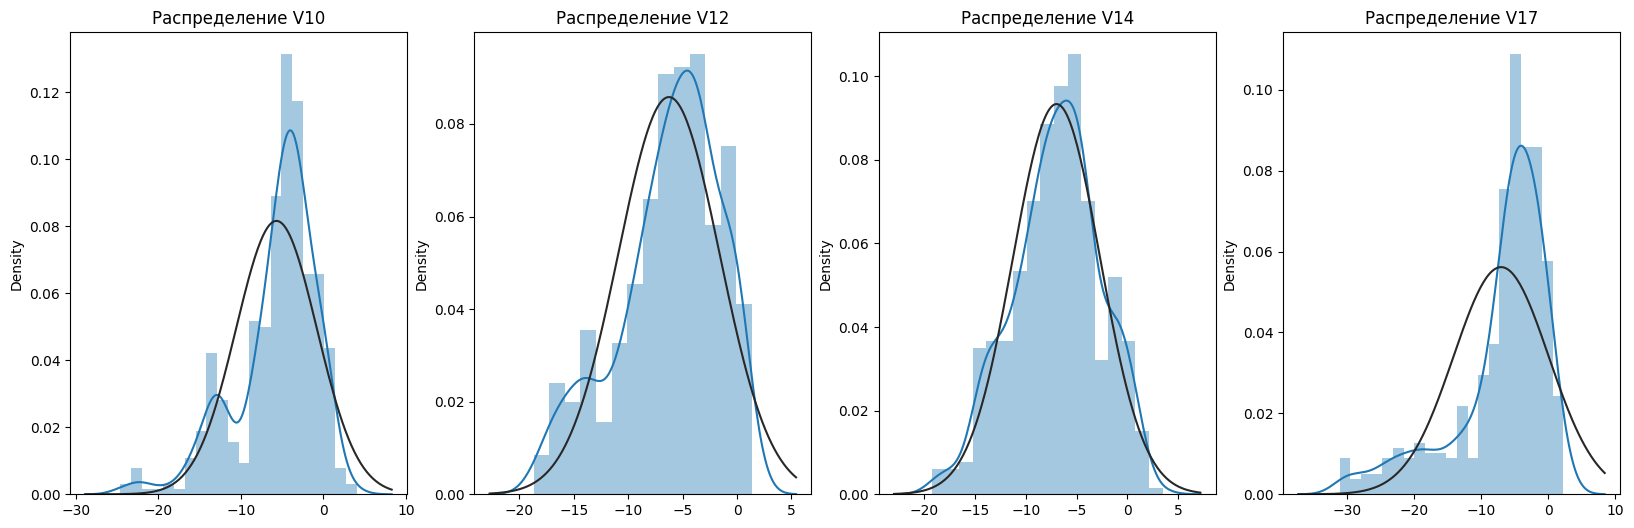

In [82]:
# Строим распределения для признаков с отрицательной корреляцией
from scipy.stats import norm

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20, 6))

####
v10 = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10, ax=ax1, fit=norm)
ax1.set_title('Распределение V10')

####
v12 = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12, ax=ax2, fit=norm)
ax2.set_title('Распределение V12')

####
v14 = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14, ax=ax3, fit=norm)
ax3.set_title('Распределение V14')

####
v17 = new_df['V17'].loc[new_df['Class'] == 1].values
sns.distplot(v3, ax=ax4, fit=norm,)
ax4.set_title('Распределение V17')


In [72]:
# Удаление выбросов из признака V17
v17_fraud = new_df['V17'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v17_fraud, 25), np.percentile(v17_fraud, 75)
print('Квартиль 25: {} | Квартиль 75: {}'.format(q25, q75))
v17_iqr = q75 - q25
print('iqr: {}'.format(v17_iqr))

v17_cut_off = v17_iqr * 1.5
v17_lower, v17_upper = q25 - v17_cut_off, q75 + v17_cut_off
print('Порог: {}'.format(v17_cut_off))
print('V17 нижняя граница: {}'.format(v17_lower))
print('V17 верхняя граница: {}'.format(v17_upper))

outliers = [x for x in v17_fraud if x < v17_lower or x > v17_upper]
print('Количество выбросов: {}'.format(len(outliers)))

new_df_without_outliers  = new_df.drop(new_df[(new_df['V17'] > v17_upper) | (new_df['V17'] < v17_lower)].index)
print('----' * 44)



#### Для остальных признаков на основе V17 описать функцию, в качастве параметра которой будут вытупать выбросы других признаков
### Написать вызов функции по нужным признакам

def detect_outliers(new_df, column_name):
    fraud_values = new_df[column_name].loc[new_df['Class'] == 1].values
    q25, q75 = np.percentile(fraud_values, 25), np.percentile(fraud_values, 75)
    print(f'Квартиль 25: {q25} | Квартиль 75: {q75}')
    iqr = q75 - q25
    print(f'iqr: {iqr}')

    cut_off = iqr * 1.5
    lower_bound, upper_bound = q25 - cut_off, q75 + cut_off
    print(f'Порог: {cut_off}')
    print(f'{column_name} нижняя граница: {lower_bound}')
    print(f'{column_name} верхняя граница: {upper_bound}')

    outliers = [x for x in fraud_values if x < lower_bound or x > upper_bound]
    print(f'Количество выбросов: {len(outliers)}')

    new_df_without_outliers = new_df.drop(new_df[(new_df[column_name] > upper_bound) | (new_df[column_name] < lower_bound)].index)
    print('----' * 44)

    return new_df_without_outliers

detect_outliers(new_df, 'V14')
detect_outliers(new_df, 'V12')
detect_outliers(new_df, 'V10')

Квартиль 25: -11.945057187644576 | Квартиль 75: -1.34193993162032
iqr: 10.603117256024255
Порог: 15.904675884036383
V17 нижняя граница: -27.84973307168096
V17 верхняя граница: 14.562735952416062
Количество выбросов: 0
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Квартиль 25: -9.692722964972386 | Квартиль 75: -4.282820849486865
iqr: 5.409902115485521
Порог: 8.114853173228282
V14 нижняя граница: -17.807576138200666
V14 верхняя граница: 3.8320323237414167
Количество выбросов: 4
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Квартиль 25: -8.688176521812306 | Квартиль 75: -2.97408802538493
iqr: 5.714088496427376
Порог: 8.571132744641064
V12 нижняя граница: -17.25930926645337
V12 верхняя граница: 5.597044719256134
Количество выбросов:

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
43747,41638.0,-1.528994,0.131047,1.420425,-2.689301,-0.783674,-0.253696,-0.062671,-0.117759,-0.898676,...,-0.727931,-0.990011,-0.227244,-0.529867,0.701119,-0.347603,0.566393,0.222509,30.00,0
154668,102480.0,-1.929597,4.066413,-4.865184,5.898602,-0.552493,-1.555962,-3.833623,0.679512,-3.463765,...,1.137212,0.674245,-0.531765,-0.433409,0.378659,0.198107,0.869694,0.228048,0.00,1
228043,145335.0,-0.853725,0.025458,0.267742,-0.251345,-0.875343,-0.313978,-1.254305,1.051035,1.475639,...,0.298260,0.925502,0.347505,1.192149,-2.313992,-0.451988,0.152706,0.112506,10.40,0
44001,41743.0,-2.144411,1.073499,-2.773663,1.384394,-4.015477,0.747235,1.525638,0.192988,-2.431862,...,0.144653,-0.885682,0.625099,0.096527,-0.189455,0.532908,0.423045,-0.210266,802.52,1
233258,147501.0,-1.611877,-0.408410,-3.829762,6.249462,-3.360922,1.147964,1.858425,0.474858,-3.838399,...,1.245582,0.616383,2.251439,-0.066096,0.538710,0.541325,-0.136243,-0.009852,996.27,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262560,160537.0,0.567539,3.309385,-6.631268,6.394574,-0.054172,-2.396535,-2.792489,0.514811,-3.541780,...,0.614221,-0.365047,-0.180409,-0.523271,0.645054,0.246466,0.902675,0.473571,4.69,1
167184,118532.0,-5.961457,5.313382,-6.674320,6.028975,-1.387560,0.670638,-4.128987,-4.765894,-1.005259,...,5.556642,-1.501808,1.355172,0.141093,0.077913,0.473988,0.287129,1.468653,105.89,1
232325,147128.0,2.030720,-1.996815,-0.124240,-1.538481,-2.021411,-0.034834,-1.794754,0.147732,-0.788609,...,-0.051864,0.101042,0.226954,-0.383717,-0.609366,-0.262996,0.036804,-0.027720,109.72,0
240222,150494.0,1.852889,1.069593,-1.776101,4.617410,0.770413,-0.400859,-0.040970,0.089510,-0.217705,...,-0.157869,-0.176244,0.027437,-0.468006,0.058063,0.148263,0.042278,0.040573,1.00,1


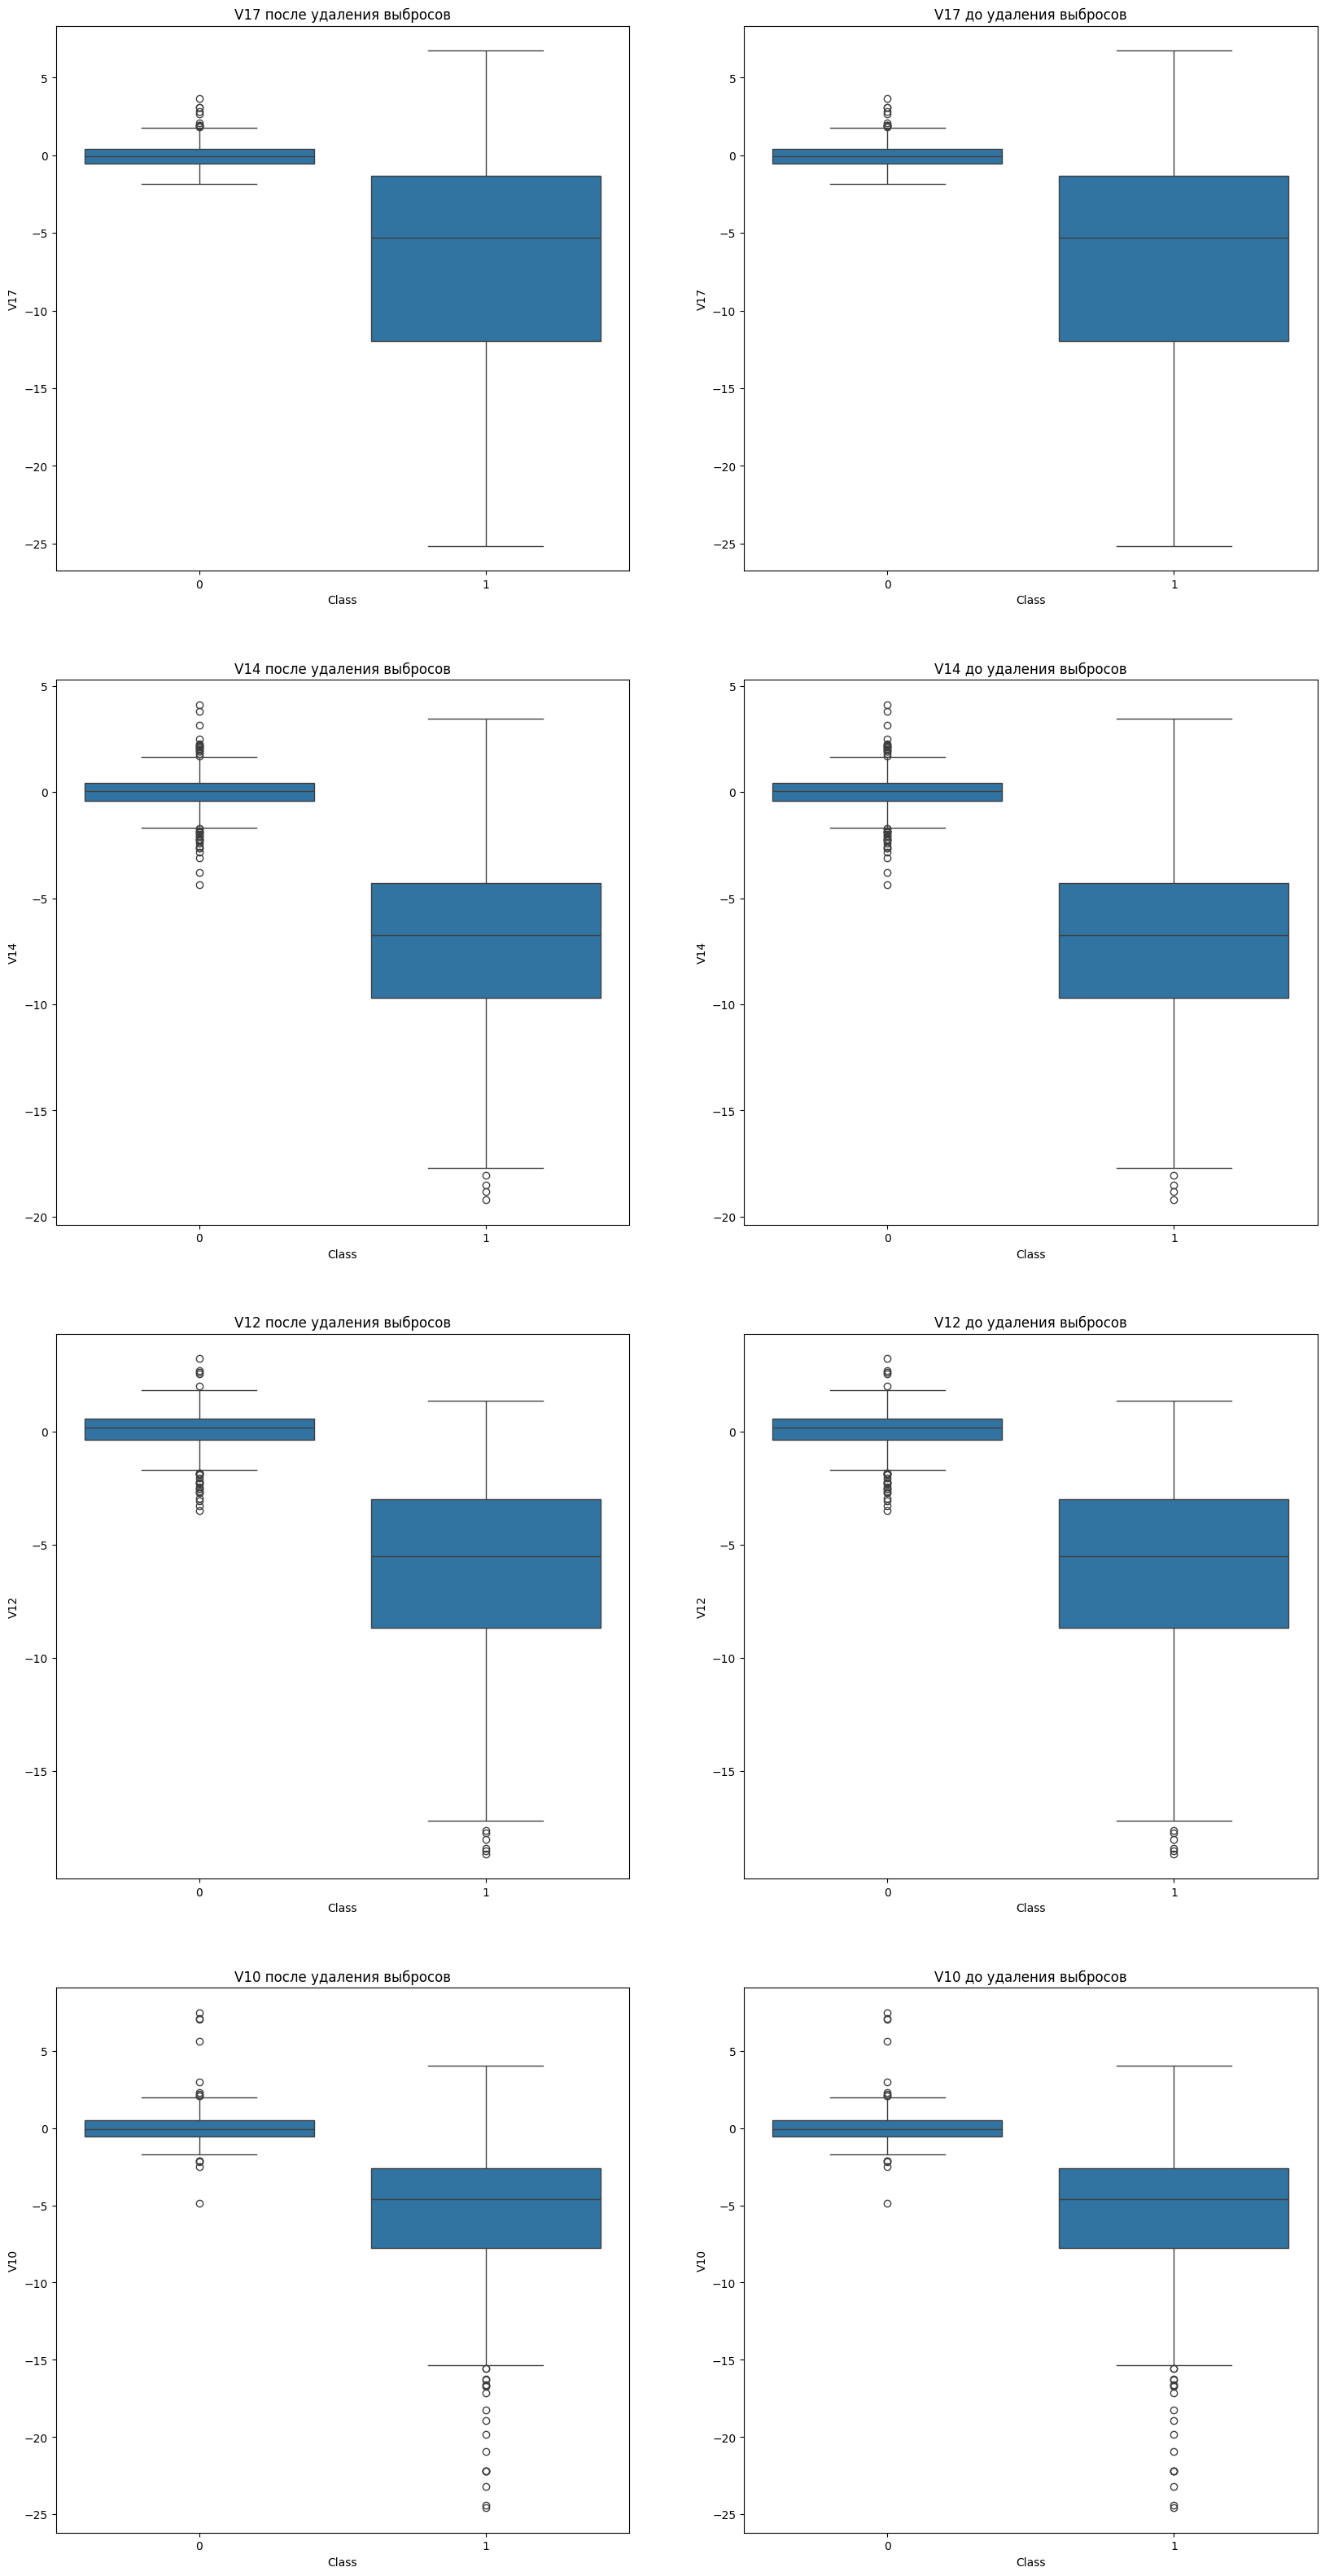

In [77]:
f, ax = plt.subplots(4, 2, figsize=(20,40))

colors = ['#B3F9C5', '#f9c5b3']

# Boxplot для признака V17 после удаления выбросов
ax[0,0].set_title('V17 после удаления выбросов')
sns.boxplot(x='Class', y='V17', data=new_df_without_outliers, ax=ax[0,0])

# Boxplot для признака V17 до удаления выбросов
ax[0,1].set_title('V17 до удаления выбросов')
sns.boxplot(x='Class', y='V17', data=new_df, ax=ax[0,1])

# И для остальных признаков тоже

# Boxplot для признака V14 после удаления выбросов
ax[1,0].set_title('V14 после удаления выбросов')
sns.boxplot(x='Class', y='V14', data=new_df_without_outliers, ax=ax[1,0])

# Boxplot для признака V14 до удаления выбросов
ax[1,1].set_title('V14 до удаления выбросов')
sns.boxplot(x='Class', y='V14', data=new_df, ax=ax[1,1])

# Boxplot для признака V12 после удаления выбросов
ax[2,0].set_title('V12 после удаления выбросов')
sns.boxplot(x='Class', y='V12', data=new_df_without_outliers, ax=ax[2,0])

# Boxplot для признака V12 до удаления выбросов
ax[2,1].set_title('V12 до удаления выбросов')
sns.boxplot(x='Class', y='V12', data=new_df, ax=ax[2,1])

# Boxplot для признака V10 после удаления выбросов
ax[3,0].set_title('V10 после удаления выбросов')
sns.boxplot(x='Class', y='V10', data=new_df_without_outliers, ax=ax[3,0])

# Boxplot для признака V10 до удаления выбросов
ax[3,1].set_title('V10 до удаления выбросов')
sns.boxplot(x='Class', y='V10', data=new_df, ax=ax[3,1])


plt.show()

In [ ]:
# теперь у нас в датафрейме new_df будут лежать данные без выбросов.

new_df = new_df_without_outliers

### Понижение размерности и кластеризация

Для того, чтобы убедиться, что наши классы являются разделимыми (иначе строить модели нет смысла), выполним кластеризацию с помощью трех различных техник кластеризации.



In [80]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

X = new_df.drop('Class', axis=1)
y = new_df['Class']

X.drop(['Time','Amount'], axis=1, inplace=True) # Tак как Time и Amount не коррелируют почти с таргетом


# T-SNE алгоритм
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=30).fit_transform(X.values)
# ВАШ КОД ЗДЕСЬ
t1 = time.time()
print("T-SNE заняло {:.2} сек".format(t1 - t0))

# PCA алгоритм
t0 = time.time()
# ВАШ КОД ЗДЕСЬ
X_reduced_pca = PCA(n_components=2, random_state=30).fit_transform(X.values)
t1 = time.time()
print("PCA заняло {:.2} сек".format(t1 - t0))

# TruncatedSVD алгоритм
t0 = time.time()
# ВАШ КОД ЗДЕСЬ
X_reduced_svd = TruncatedSVD(n_components=2, random_state=30).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD заняло {:.2} сек".format(t1 - t0))

T-SNE заняло 9.8 сек
PCA заняло 0.0026 сек
Truncated SVD заняло 0.087 сек


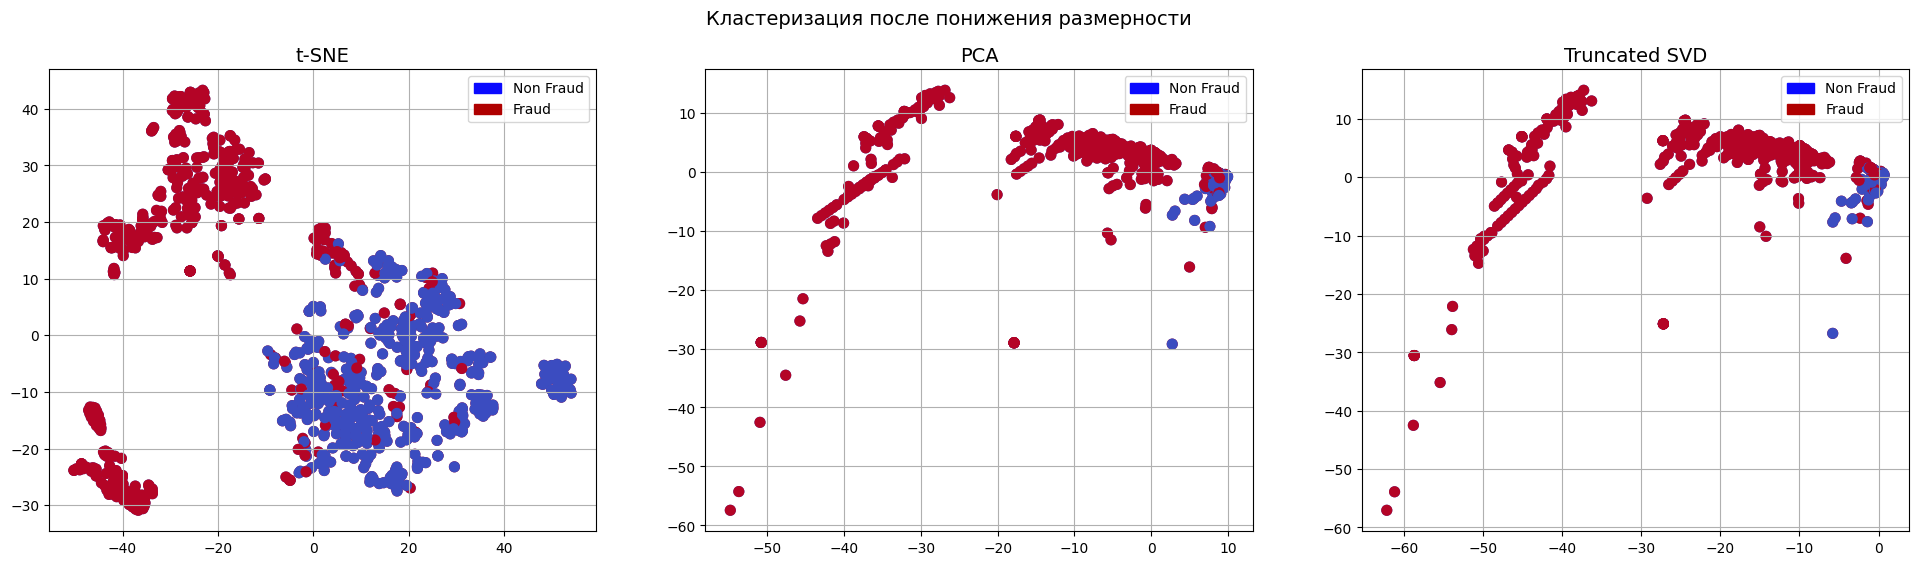

In [81]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
f.suptitle('Кластеризация после понижения размерности', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='Non Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='Non Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='Non Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='Non Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

<h3> Выводы: </h3>
<ul>
<li>Алгоритм t-SNE может довольно точно кластеризовать случаи мошенничества и не мошенничества в нашем наборе данных. </li>
<li> Классы целевой переменной однозначно разделимы, а значит мы можем строить модели! </li>
</ul>

## Продолжение следует .....



<h3 style="text-align: center;">Материалы для изучения scikit-learn:<b></b></h3>

*1) Официальный сайт с подробными описаниями моделей и методов : https://scikit-learn.org/stable/user_guide.html*

*2) Полезный репозиторий с блокнотами: https://github.com/gmonce/scikit-learn-book*

*3) Хороший курс с упражнениями: https://inria.github.io/scikit-learn-mooc/*

In [ ]:
new_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/creditcard_short.csv')